In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm

from numpy import linalg as LA

%matplotlib inline

1. Extract users that performed actions over the target projects

In [2]:
categories = {
    'watch': ['WatchEvent'],
    'interact': ['CommitCommentEvent', 'GollumEvent', 'PullRequestReviewCommentEvent','IssuesEvent', 'IssueCommentEvent',
                'ForkEvent'],
    'contribute': ['CreateEvent', 'DeleteEvent', 'PullRequestEvent', 'PushEvent','ReleaseEvent', 'MemberEvent']
}
cat_list = ['contribute','interact','watch']

def define_category(event):
    for c in categories.keys():
        if event in categories[c]:
            return c
    # return 'other' # includes forks and not known/already seen events

In [3]:
# return maximum normalized value
def get_perc_distr(row, clist):
    sum_a = sum([row[c] for c in clist])
    
    #norm_row = {}
    max_norm = 0
    for c in clist:
        norm_row = float(row[c])/sum_a
        if norm_row > max_norm:
            max_norm = norm_row
        
    return max_norm

In [4]:
path = '../data/'

In [5]:
# data import
# a15 = pd.read_csv(path + 'activity_2015.csv', parse_dates=['timestamp'])
a16 = pd.read_csv(path + 'activity_2016.csv', parse_dates=['timestamp'])

In [6]:
# a = pd.concat([a15, a16])
a = a16
a.head()

,source,target,event,timestamp
0,289412,507775,IssueCommentEvent,2016-01-18 23:00:00
1,546885,29028775,IssueCommentEvent,2016-01-18 23:00:04
2,463737,45717250,PullRequestEvent,2016-01-18 23:00:06
3,8566911,23096959,IssueCommentEvent,2016-01-18 23:00:13
4,827131,7691631,IssueCommentEvent,2016-01-18 23:00:16


In [7]:
a['cat'] = a['event'].apply(lambda x: define_category(x))

## Distribution of #projects over users

In [8]:
# unique users that performed activites on target projects
len(a['source'].unique())

721187

In [9]:
# unique users that performed activites on target projects except for watching (passive action)
len(a[a['cat'] != 'watch']['source'].unique())

302904

In [10]:
# store to filter json files
# pd.DataFrame(activities[activities['cat'] != 'watch']['source'].unique(), columns=['id_user'])\
#                                        .to_csv('data/users_with_project_interactions.csv', index=None)

#### Multiple-projects collaboration: **non-watch** on multiple repositories

In [79]:
u_projects = a[~a['event'].isin(['WatchEvent'])].groupby(by='source')['target'].apply(list)  # , 'ForkEvent'
u_projects.head()

source
4     [724712, 724712, 724712, 724712, 724712, 72471...
7     [8514, 8514, 8514, 8514, 20580498, 20580498, 2...
21                                  [3228505, 23096959]
22                                   [8514, 8514, 8514]
29                                           [45717250]
Name: target, dtype: object

In [80]:
u_proj_distr = u_projects.apply(lambda x: len(set(x)))

In [81]:
u_proj_distr.value_counts(normalize=True)[:10]

1     0.811680
2     0.123442
3     0.035543
4     0.013503
5     0.006421
6     0.003457
7     0.001855
8     0.001208
9     0.000759
10    0.000475
Name: target, dtype: float64

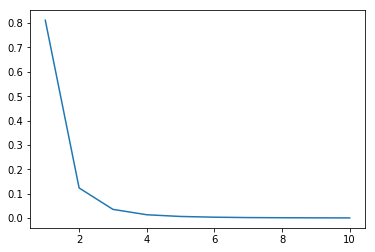

In [82]:
u_proj_distr.value_counts(normalize=True)[:10].plot()

In [83]:
u_projects = pd.DataFrame(u_projects)

In [84]:
u_projects['count'] = u_projects['target'].apply(lambda x: len(set(x)))

In [85]:
target_users = u_projects[u_projects['count'] > 1].index.values

In [86]:
target_users.shape

(57043,)

Distribution of activities of users with multiple projects

In [87]:
t_a = a[a['source'].isin(target_users)]

In [88]:
t_a.shape

(1130925, 5)

In [89]:
u_multi = t_a.groupby(['source', 'target'])[['event']].count()
u_multi.head()

event
source target         
4      724712        6
       41881900      1
7      8514          7
       20580498      3
21     3228505       1

In [90]:
u_multi_all = u_multi.reset_index().pivot(index='source', columns='target', values='event').fillna(0)
u_multi_all.head()

target,8514,65252,156018,167174,211666,237159,291137,317757,349241,460078,...,29028775,29268051,33614304,35955666,36535156,41881900,44838949,45717250,46629305,56717493
source,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
u_multi_all_max  = u_multi_all
u_multi_all_max['max'] = u_multi_all.apply(lambda x: max(x), axis=1)

In [92]:
u_multi_all_max[u_multi_all_max['max'] > 3].shape

(12716, 98)

In [93]:
plist = a['target'].unique()

In [94]:
u_multi_max = u_multi_all_max[u_multi_all_max['max'] > 3].drop('max', axis=1).apply(lambda x: get_perc_distr(x, plist), axis=1)

Text(0.5,0,'%activities')

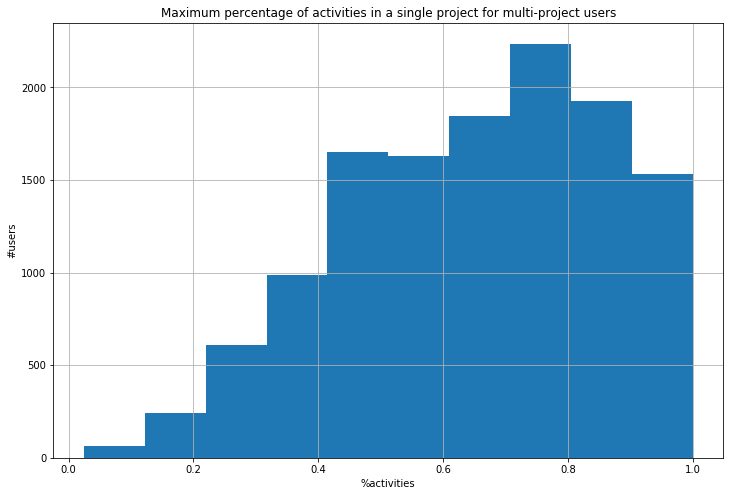

In [95]:
u_multi_max.hist(figsize=(12, 8))
plt.title('Maximum percentage of activities in a single project for multi-project users')
plt.ylabel('#users')
plt.xlabel('%activities')

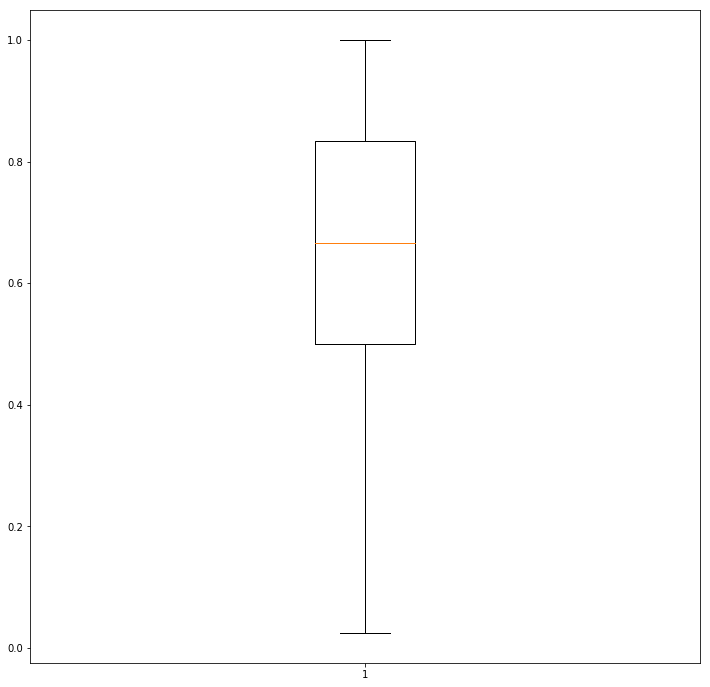

In [96]:
plt.figure(figsize=(12, 12))
plt.boxplot(u_multi_max);

Collaboration graphs of users with multiple projects

In [28]:
# nodes
nodes = u_multi_all_max[u_multi_all_max['max'] > 200]['max'].reset_index()
nodes.columns = ['id', 'max_activities']
nodes.to_csv('graphs/nodes_multiproject.csv', index=None)

In [29]:
# edges: matrix multiplication to get similarity
M = u_multi_all_max[u_multi_all_max['max'] > 200].drop('max', axis=1)
E = M.dot(M.transpose(copy=True))

In [30]:
E.shape

(450, 450)

In [31]:
E.head()

source,354,1050,1396,1789,2289,2621,2741,2815,3124,3622,...,16774510,16890566,16943353,17894459,18046309,18107181,18572518,19172805,20082558,23558090
source,,,,,,,,,,,,,,,,,,,,,
354,3339610.0,85157.0,0.0,0.0,0.0,38531.0,0.0,0.0,0.0,0.0,...,376247.0,0.0,32886.0,456996.0,429427.0,663365.0,0.0,1595012.0,78136.0,0.0
1050,85157.0,4313930.0,0.0,0.0,0.0,12901.0,0.0,0.0,0.0,0.0,...,456940.0,0.0,0.0,12462.0,4154.0,8308.0,0.0,2077.0,533789.0,0.0
1396,0.0,0.0,456280.0,118734.0,563784.0,0.0,0.0,0.0,0.0,60130.0,...,0.0,21408.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,186.0
1789,0.0,0.0,118734.0,1383172.0,17668.0,0.0,0.0,0.0,0.0,608244.0,...,0.0,448.0,0.0,0.0,0.0,0.0,1176.0,0.0,0.0,2352.0
2289,0.0,0.0,563784.0,17668.0,709030.0,0.0,0.0,0.0,0.0,17741.0,...,0.0,26944.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,10.0


In [32]:
E.values[[np.arange(len(E))]*2] = 0

In [33]:
del E.index.name

In [34]:
idx = E.columns.values
idx

array([     354,     1050,     1396,     1789,     2289,     2621,
           2741,     2815,     3124,     3622,     4303,     5213,
           5676,     5750,     6820,     7171,     7208,     7288,
           8445,     9293,    11214,    13760,    15655,    15952,
          16018,    16124,    17607,    17882,    22350,    23068,
          23123,    23304,    27786,    28492,    33544,    37310,
          37586,    38349,    42211,    44136,    45469,    47395,
          49258,    49262,    51265,    54485,    54666,    55547,
          59744,    61586,    63648,    64996,    67496,    67512,
          69169,    70861,    73085,    79017,    81672,    90494,
          93018,    95713,    98681,    99763,   100893,   101445,
         101513,   104030,   104052,   106475,   106625,   107032,
         108380,   111951,   115237,   118951,   119737,   119893,
         127379,   129061,   131916,   132260,   134460,   135652,
         150330,   157083,   157858,   158611,   158859,   161

In [35]:
E = E.values
E

array([[0.000000e+00, 8.515700e+04, 0.000000e+00, ..., 1.595012e+06,
        7.813600e+04, 0.000000e+00],
       [8.515700e+04, 0.000000e+00, 0.000000e+00, ..., 2.077000e+03,
        5.337890e+05, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 1.860000e+02],
       ...,
       [1.595012e+06, 2.077000e+03, 0.000000e+00, ..., 0.000000e+00,
        3.255800e+04, 0.000000e+00],
       [7.813600e+04, 5.337890e+05, 0.000000e+00, ..., 3.255800e+04,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 1.860000e+02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [55]:
from joblib import Parallel, delayed
import multiprocessing

 
def processInput(submatrix, isDiag):
    edges = []
    if isDiag:
        for i in range(submatrix.shape[0]):
            for j in range(i, submatrix.shape[1]):
                w = submatrix[i][j]
                if w > 0:
                    edges.append(tuple((idx[i], idx[j], w)))
    else:
        for i in range(submatrix.shape[0]):
            for j in range(submatrix.shape[1]):
                w = submatrix[i][j]
                if w > 0:
                    edges.append(tuple((idx[i], idx[j], w)))
    return edges

In [37]:
num_cores = multiprocessing.cpu_count()

In [38]:
E.shape

(450, 450)

In [62]:
n = int(np.sqrt(E.shape[0]**2/6))
n

183

In [43]:
N = E.shape[0]

In [63]:
submatrices = []
start_row = 0
start_col = 0
end_row = n
end_col = n
for i in range(6):

    submatrices.append(E[start_row:end_row, start_col:end_col])
    
    start_col = end_col
    end_col = end_col + n
    
    if i == 2:
        start_row = end_row
        end_row = end_row + n
        start_col = n
        end_col = 2*n
        
    elif i == 4:
        start_row = end_row
        end_row = end_row + n
        start_col = 2*n
        end_col = 3*n
        
    # avoid outflow
    if end_col >= N:
        end_col = N
    if end_row >= N:
        end_row = N

In [66]:
for m in submatrices:
    print(m.shape)

(183, 183)
(183, 183)
(183, 84)
(183, 183)
(183, 84)
(84, 84)


In [67]:
results = Parallel(n_jobs=num_cores)\
         (delayed(processInput)(m, is_diag) for m, is_diag in zip(submatrices,[True, False, False, True, False, True]))

In [68]:
len(results)

6

In [69]:
edges = []
for r in results:
    edges = edges + r

In [70]:
len(edges), pd.DataFrame(edges).drop_duplicates().shape[0]

(28751, 28507)

Timeseries of activities for users with multiple projects

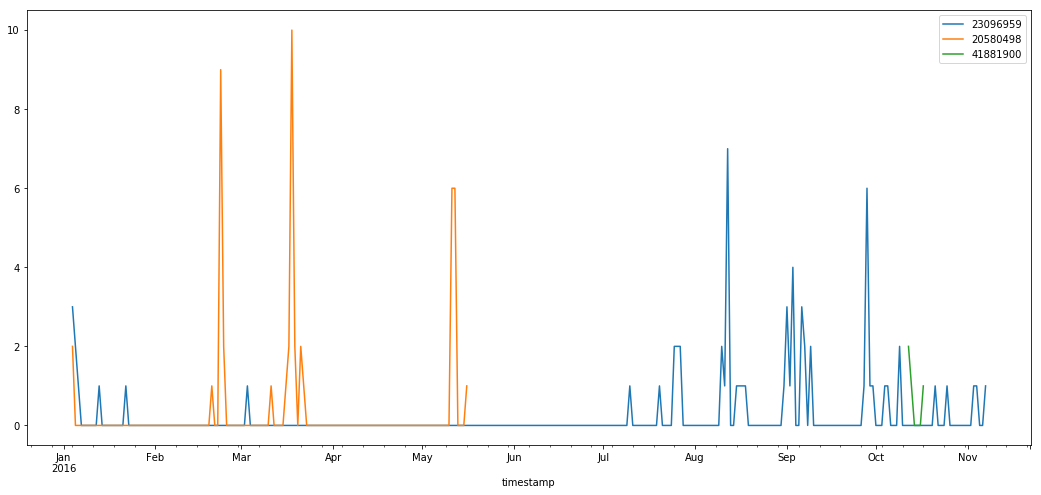

In [69]:
plt.figure(figsize=(18, 8))
u = t_a[t_a['source'] == 103]

for p in u['target'].unique():
    u_p = u[u['target'] == p]
    u_p = u_p.resample('D', on='timestamp').count()[['target']]
    u_p.columns = [p]
    u_p.plot(ax = plt.gca())

In [99]:
target_users_time = u_multi_all_max[u_multi_all_max['max'] > 3].index.values

In [104]:
# read instead of recomputation

'''
all_ts = pd.DataFrame()
for u in tqdm(target_users_time):
    user = t_a[t_a['source'] == u]
    ts = user.resample('M', on='timestamp')['target'].apply(set).apply(lambda x: len(x))
    ts.columns = [u]
    
    all_ts = pd.concat([all_ts, ts], axis=1)
'''
all_ts = pd.read_csv('multiproject_timeseries.csv', index='timestamp', parse_dates=['timestamp'])

100%|██████████| 12716/12716 [1:42:47<00:00,  2.06it/s]


In [109]:
# all_ts.fillna(0).to_csv('multiproject_timeseries.csv')

In [106]:
all_ts.shape

(12, 12716)

In [190]:
parallel_collab = all_ts.fillna(0).transpose()

In [152]:
date_lab = [d.strftime('%b %Y') for d in parallel_collab.columns]
date_lab

['Jan 2016',
 'Feb 2016',
 'Mar 2016',
 'Apr 2016',
 'May 2016',
 'Jun 2016',
 'Jul 2016',
 'Aug 2016',
 'Sep 2016',
 'Oct 2016',
 'Nov 2016',
 'Dec 2016']

Text(0,0.5,'#projects')

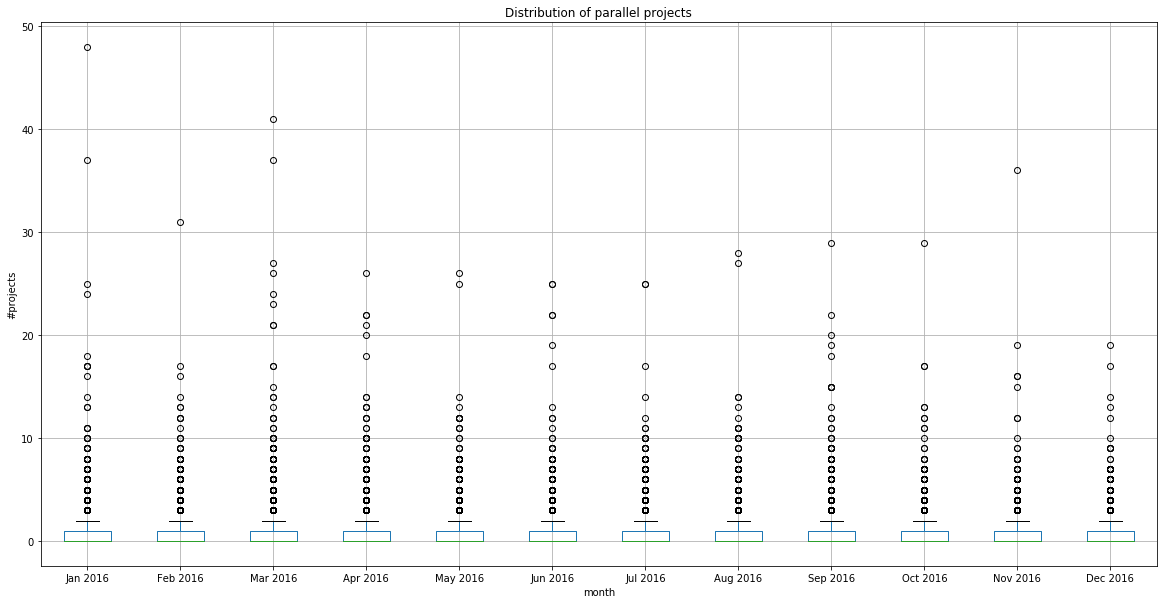

In [158]:
parallel_collab.boxplot(figsize=(20, 10))
plt.xticks(range(1, 13), date_lab);

plt.title('Distribution of parallel projects')
plt.xlabel('month')
plt.ylabel('#projects')

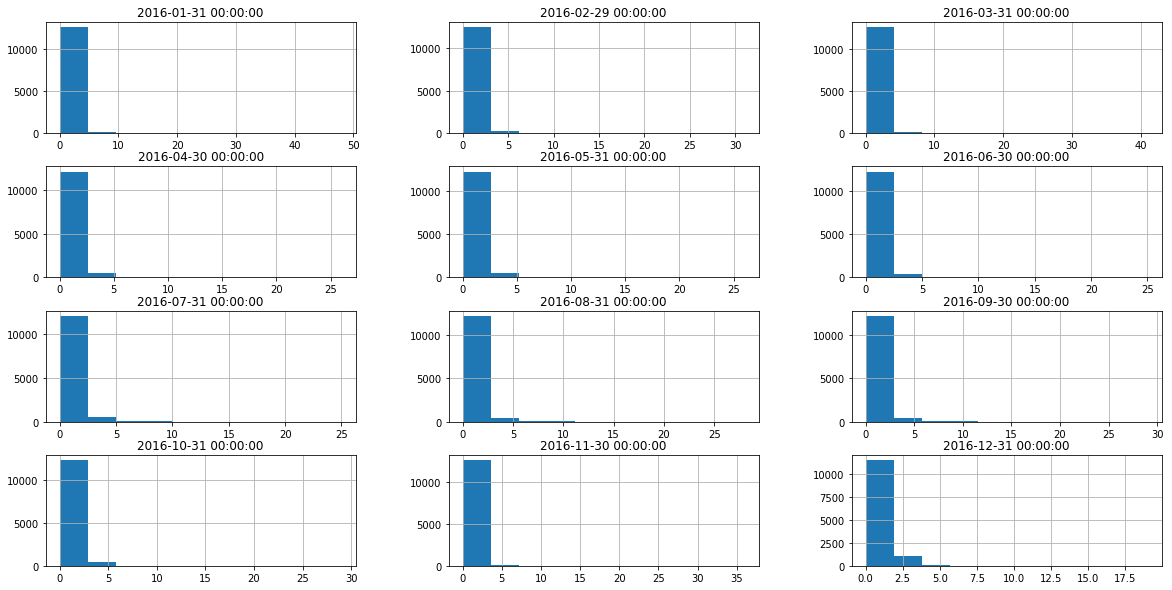

In [191]:
parallel_collab.hist(figsize=(20, 10));

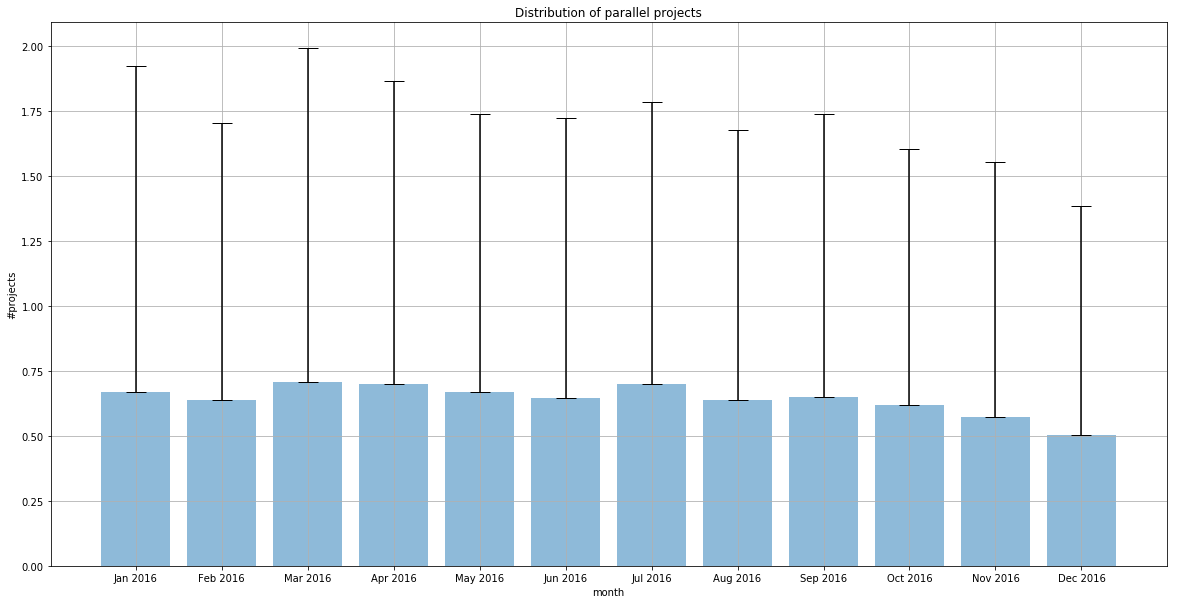

In [159]:
plt.figure(figsize=(20, 10))
x_pos = range(12)
mean_vals = parallel_collab.mean()
error = parallel_collab.std()

plt.bar(x_pos, mean_vals, align='center', alpha=0.5)
plt.errorbar(x_pos, mean_vals, yerr=[[0]*12, error], ecolor='black', capsize=10, fmt='none')
plt.grid()
plt.xticks(range(12), date_lab)

plt.title('Distribution of parallel projects')
plt.xlabel('month')
plt.ylabel('#projects');

In [197]:
desc = parallel_collab.describe()
desc

timestamp,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2016-05-31 00:00:00,2016-06-30 00:00:00,2016-07-31 00:00:00,2016-08-31 00:00:00,2016-09-30 00:00:00,2016-10-31 00:00:00,2016-11-30 00:00:00,2016-12-31 00:00:00
count,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000,12716.000000
mean,0.666955,0.638251,0.706040,0.701085,0.667270,0.647295,0.699906,0.637465,0.647845,0.619770,0.573608,0.504954
std,1.256820,1.063754,1.285485,1.164990,1.070801,1.074171,1.082693,1.040536,1.091167,0.982369,0.979142,0.879740
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,48.000000,31.000000,41.000000,26.000000,26.000000,25.000000,25.000000,28.000000,29.000000,29.000000,36.000000,19.000000


In [195]:
nov = parallel_collab.columns[10]

In [203]:
month_outlier

,target,target
timestamp,,
2016-01-31,0.0,0.0
2016-02-29,0.0,1.0
2016-03-31,0.0,1.0
2016-04-30,1.0,20.0
2016-05-31,8.0,7.0
2016-06-30,25.0,25.0
2016-07-31,6.0,6.0
2016-08-31,4.0,0.0
2016-09-30,3.0,0.0


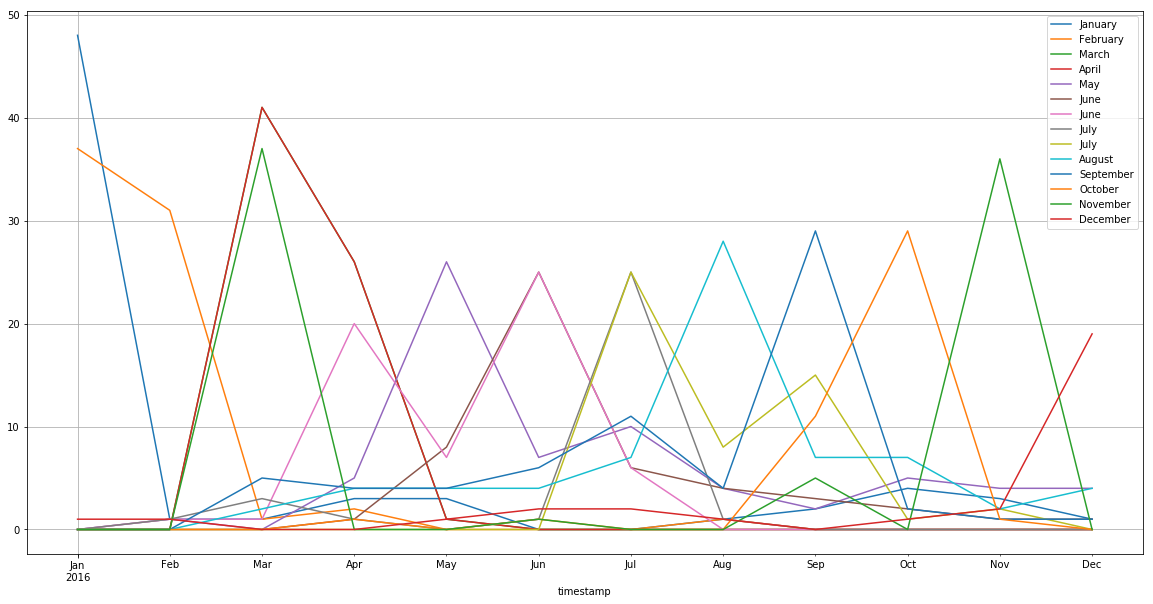

In [208]:
plt.figure(figsize=(20, 10))
for month in parallel_collab.columns:
    month_max = desc.loc['max', month]
    
    month_outliers = parallel_collab[parallel_collab[month] == month_max].transpose()
    n_outliers = month_outliers.shape[1]
    
    month_outliers.columns = [month.strftime('%B')]*n_outliers
    month_outliers.plot(ax=plt.gca())
plt.grid()

#### Multiple watchers: watch on multiple repositories

In [16]:
u_watch = a[a['cat'] == 'watch'].groupby(by='source')['target'].apply(list)
u_watch.head()

source
17               [291137]
23              [8843683]
31             [28457823]
34    [45717250, 9384267]
35     [557980, 18408635]
Name: target, dtype: object

In [17]:
u_watch_distr = u_watch.apply(lambda x: len(set(x)))

In [28]:
u_fork = a[a['event'] == 'ForkEvent'].groupby(by='source')['target'].apply(list)
u_fork_distr = u_fork.apply(lambda x: len(set(x)))

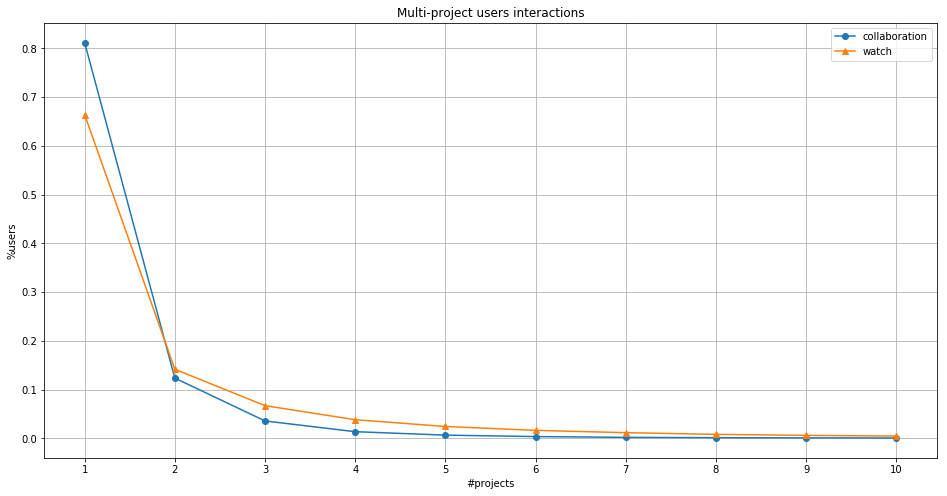

In [68]:
N = 10
plt.figure(figsize=(16, 8))

u_proj_distr.value_counts(normalize=True).sort_index()[:N].plot(label='collaboration', marker='o')
u_watch_distr.value_counts(normalize=True).sort_index()[:N].plot(label='watch', marker='^')
#u_fork_distr.value_counts(normalize=True).sort_index()[:N].plot(label='fork', marker='x')

plt.grid(True)
plt.legend()
plt.xticks(range(1, 11))

plt.xlabel('#projects')
plt.ylabel('%users')
plt.title('Multi-project users interactions');

In [67]:
u_watch = pd.DataFrame(u_watch)

In [68]:
u_watch['count'] = u_watch['target'].apply(lambda x: len(set(x)))

In [69]:
target_watchers = u_watch[u_watch['count'] > 1].index.values

In [72]:
u_multiwatch = u_watch[u_watch.index.isin(target_watchers)]
u_multiwatch.shape

(176529, 2)

In [77]:
u_multiwatch['count'].value_counts()

2     74402
3     35137
4     20005
5     12704
6      8523
7      6027
8      4197
9      3114
10     2365
11     1842
12     1419
13     1157
14      994
15      689
16      565
17      481
18      393
19      341
20      281
21      247
22      229
24      164
23      146
25      129
26      106
28       89
29       82
27       80
31       63
30       60
      ...  
52        7
54        6
58        6
55        4
57        4
62        4
60        4
73        4
53        4
56        3
59        3
50        3
63        3
74        3
67        3
93        3
71        2
79        2
61        2
69        2
66        2
65        2
70        1
75        1
80        1
82        1
83        1
86        1
90        1
95        1
Name: count, Length: 79, dtype: int64